### 데이터 구성 <br>
#### data_raw 폴더 아래에
- {name}_OHLCV.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 일별 데이터
- 첫 행 : Date, Close, High, Low, Open, Volume, Ticker
- 둘째 행 : , GLD, GLD, GLD, GLD, GLD

#### monthly_return 폴더 아래에
- {name}_monthly_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 리턴 (월간 수익률) 데이터
- 첫 행 : Date, Monthly Return

#### data_monthly 폴더 아래에
- {name}_monthly.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 가격 (월간 종가) 데이터
- 첫 행 : Date, Monthly Close

#### dividend_data 폴더 아래에
- {name}_dividends.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT 존재 (GLD는 없음)
- 배당 데이터
- 첫 행 : Date, Dividend

#### total_return 폴더 아래에
- {name}_total_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 배당 재투자 반영한 누적 수익률 데이터
- 첫 행 : Date, Monthly Return, Monthly Close, Dividend Yield, Total Return, Cumulative Return

# 1. 데이터 로딩 및 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# seaborn 스타일 설정
sns.set_style('whitegrid')
sns.set_context('talk')

# 종목 리스트
tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']

# 폴더 경로
data_raw_path = './data_raw'
monthly_return_path = './monthly_return'
data_monthly_path = './data_monthly'
dividend_data_path = './dividend_data'
total_return_path = './total_return'

# 1) 일별 OHLCV 데이터 읽기
ohlcv_dfs = {}
for t in tickers:
    file = os.path.join(data_raw_path, f"{t}_OHLCV.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    ohlcv_dfs[t] = df

# 2) 월별 가격(종가) 데이터 읽기
monthly_close_dfs = {}
for t in tickers:
    file = os.path.join(data_monthly_path, f"{t}_monthly.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_close_dfs[t] = df

# 3) 월별 수익률 데이터 읽기
monthly_return_dfs = {}
for t in tickers:
    file = os.path.join(monthly_return_path, f"{t}_monthly_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_return_dfs[t] = df

# 4) 배당 데이터 (GLD 없음)
dividend_dfs = {}
for t in ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT']:
    file = os.path.join(dividend_data_path, f"{t}_dividends.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    dividend_dfs[t] = df

# 5) 배당 재투자 누적 수익률 데이터
total_return_dfs = {}
for t in tickers:
    file = os.path.join(total_return_path, f"{t}_total_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    total_return_dfs[t] = df

# 2. 포트폴리오 구성 및 계산

In [2]:
# 포트폴리오 가중치 (월별 수익률 기준)
portfolios = {
    'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
    'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
}

# 개별 종목 : SPY, SCHD, QQQ, TLT, GLD, JEPI
# 혼합 종목들은 가중 수익률 계산용 이름
mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

In [3]:
# 모든 분석할 종목 리스트 (개별 + 혼합)
all_tickers = tickers + list(mixed_tickers.keys())

# 월별 수익률 데이터로 포트폴리오 및 혼합 종목 수익률 계산
def calc_mixed_monthly_return(weights_dict, monthly_return_dfs):
    # 날짜 기준 통합 인덱스 생성
    date_index = monthly_return_dfs['SPY'].index

    # 가중 평균 수익률 계산용 DataFrame
    df = pd.DataFrame(index=date_index)

    for name, weights in weights_dict.items():
        # 종목별 월별 수익률을 가져와서 가중평균 계산
        ret = pd.Series(0, index=date_index, dtype=float)
        for t, w in weights.items():
            ret += monthly_return_dfs[t]['Monthly Return'] * w
        df[name] = ret

    return df

# 혼합 종목 월별 수익률 계산
mixed_returns_df = calc_mixed_monthly_return(mixed_tickers, monthly_return_dfs)

# 개별 종목 월별 수익률 합치기
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 전체 종목(개별+혼합) 월별 수익률 데이터프레임
all_returns_df = pd.concat([indiv_returns_df, mixed_returns_df], axis=1)

# 3. 그래프 그리기 : 박스 플롯

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 기본 한글 폰트 경로 예시
font_path = "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 폰트

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

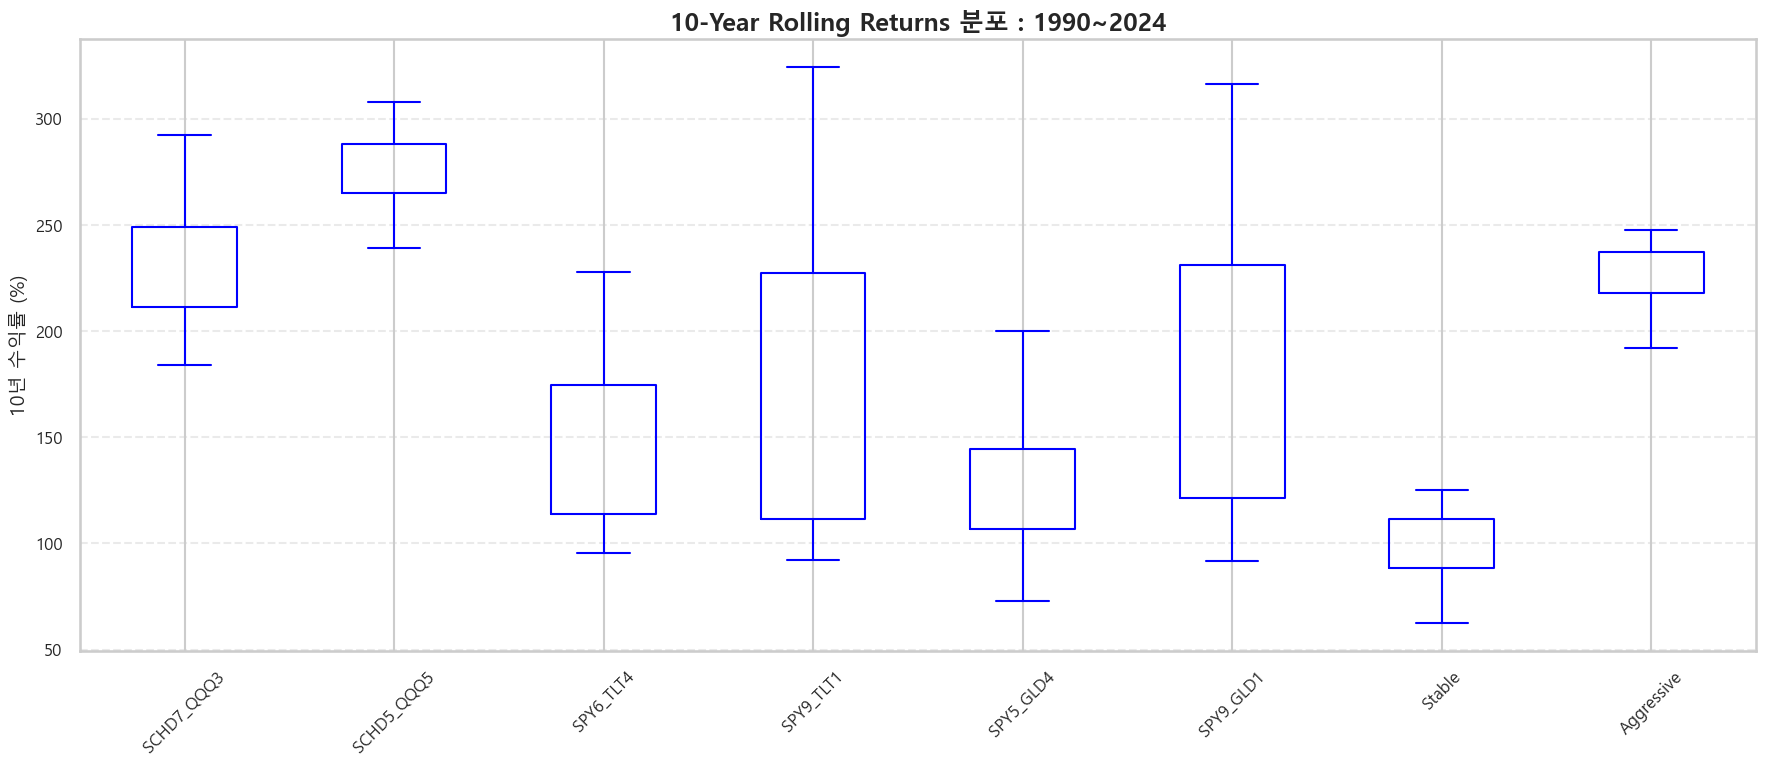

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
labels = list(rolling_10yr_returns.keys())
data = [rolling_10yr_returns[t] for t in labels]

plt.figure(figsize=(18, 8))

# 박스플롯 생성
box = plt.boxplot(data, tick_labels=labels, vert=True, patch_artist=False, showfliers=False)

# 파란색 직사각형 테두리만 (중앙값 선은 안 보이게 숨김)
for b in box['boxes']:
    b.set_color('blue')
    b.set_linewidth(1.5)

for whisker in box['whiskers']:
    whisker.set_color('blue')
    whisker.set_linewidth(1.5)

for cap in box['caps']:
    cap.set_color('blue')
    cap.set_linewidth(1.5)

for median in box['medians']:
    median.set_color('white')
    median.set_linewidth(0)

# 스타일
plt.title('10-Year Rolling Returns 분포 : 1990~2024', fontsize=18, weight='bold')
plt.ylabel('10년 수익률 (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

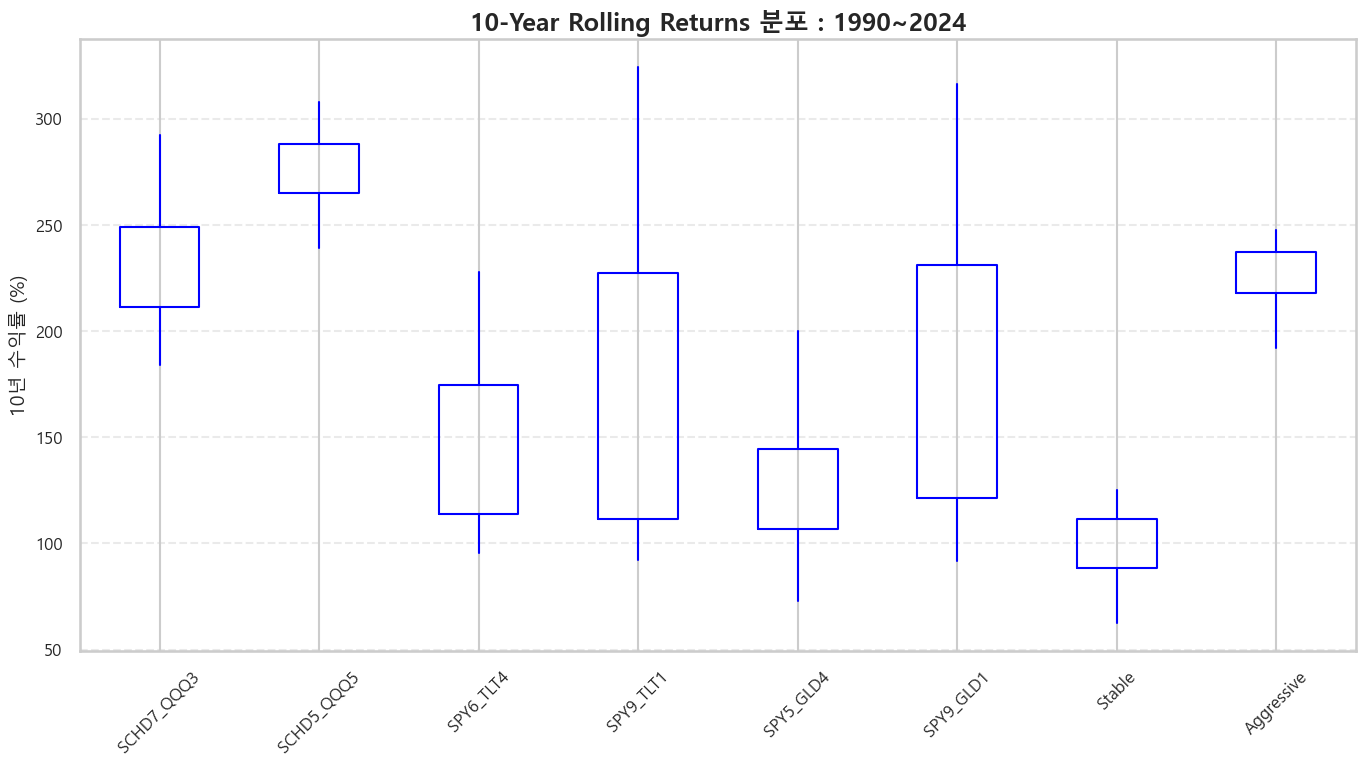

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
labels = list(rolling_10yr_returns.keys())
data = [rolling_10yr_returns[t] for t in labels]

plt.figure(figsize=(14, 8))

# 박스플롯 생성 (기본 간격 유지, 이상치 제거, 박스 채우기 없음)
box = plt.boxplot(data, tick_labels=labels, vert=True, patch_artist=False, showfliers=False)

# 파란 테두리만 유지
for b in box['boxes']:
    b.set_color('blue')
    b.set_linewidth(1.5)

for whisker in box['whiskers']:
    whisker.set_color('blue')
    whisker.set_linewidth(1.5)

# 끝단 가로선 제거
for cap in box['caps']:
    cap.set_visible(False)

# 중앙값 선 제거
for median in box['medians']:
    median.set_color('white')  # 배경과 같게
    median.set_linewidth(0)

# 스타일
plt.title('10-Year Rolling Returns 분포 : 1990~2024', fontsize=18, weight='bold')
plt.ylabel('10년 수익률 (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

JEPI - 데이터 부족으로 시각화에서 제외


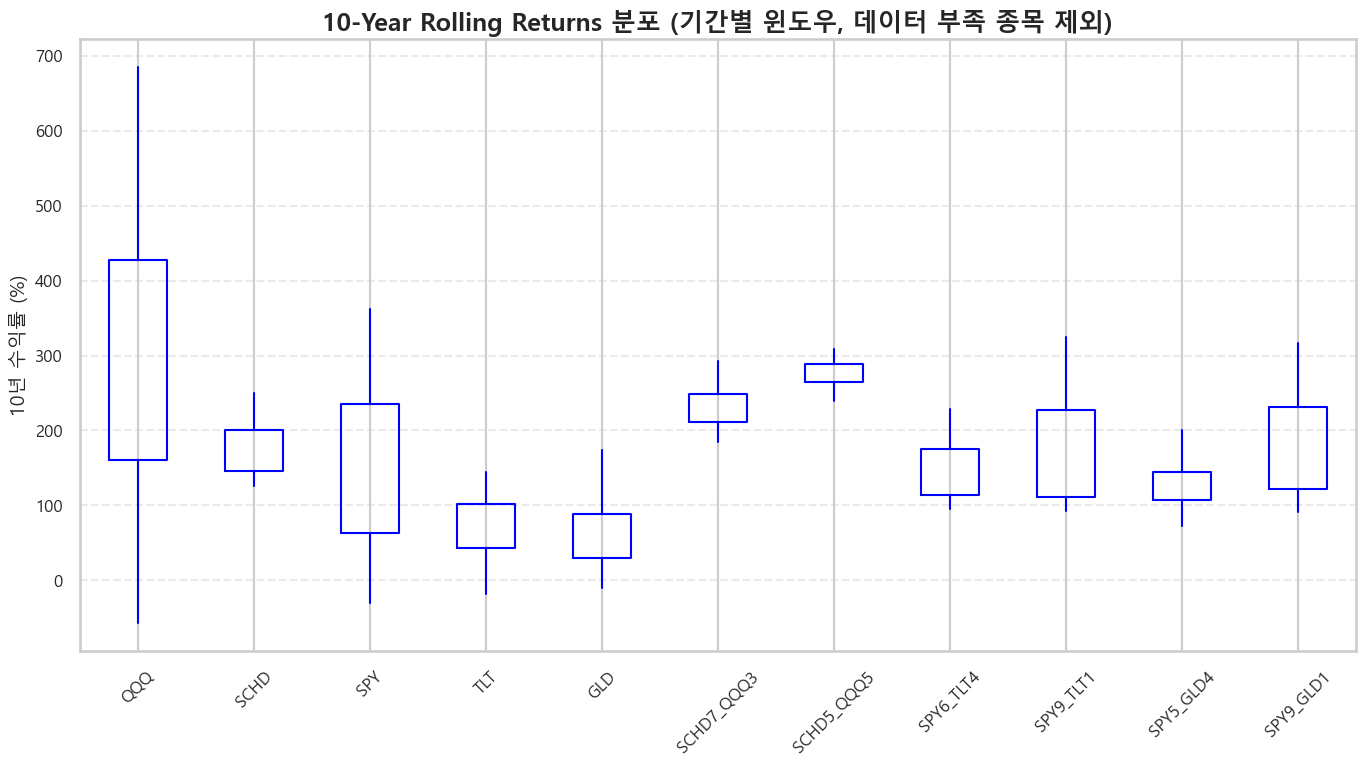

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# rolling 수익률 계산 함수 (개별 종목별로 기간에 맞게 window 조정)
def calc_rolling_returns_with_variable_window(df_returns, default_window=120, min_window=12, min_counts=30):
    """
    각 종목별로 rolling window 크기를 조절하여 누적수익률 계산.
    - 종목 기간이 짧으면 window를 줄임(min_window 이상)
    - rolling 결과가 min_counts(예:30) 미만이면 시각화 제외용 NaN 반환
    """
    rolling_returns = {}
    for col in df_returns.columns:
        series = df_returns[col].dropna()
        length = len(series)

        # window는 최소 min_window, 최대 default_window, 실제 기간 중 작은 값으로
        window = min(default_window, max(min_window, length))

        # rolling 계산 (곱적용), min_periods=window
        rolling_prod = (1 + series).rolling(window=window, min_periods=window).apply(np.prod, raw=True)

        # 충분한 rolling 결과가 있으면 저장, 아니면 NaN 시리즈 저장
        valid_vals = rolling_prod.dropna()
        if len(valid_vals) >= min_counts:
            rolling_returns[col] = (valid_vals - 1) * 100
        else:
            # NaN 시리즈로 넣어서 나중에 시각화 시 제외 가능
            rolling_returns[col] = pd.Series([np.nan])
    return rolling_returns

rolling_10yr_returns = calc_rolling_returns_with_variable_window(all_returns_df)

labels = []
data = []
for t, vals in rolling_10yr_returns.items():
    # NaN만 있으면 제외
    if vals.isna().all():
        print(f"{t} - 데이터 부족으로 시각화에서 제외")
        continue
    labels.append(t)
    data.append(vals.values)

plt.figure(figsize=(14, 8))

box = plt.boxplot(data, tick_labels=labels, vert=True, patch_artist=False, showfliers=False)

for b in box['boxes']:
    b.set_color('blue')
    b.set_linewidth(1.5)

for whisker in box['whiskers']:
    whisker.set_color('blue')
    whisker.set_linewidth(1.5)

for cap in box['caps']:
    cap.set_visible(False)

for median in box['medians']:
    median.set_color('white')
    median.set_linewidth(0)

plt.title('10-Year Rolling Returns 분포 (기간별 윈도우, 데이터 부족 종목 제외)', fontsize=18, weight='bold')
plt.ylabel('10년 수익률 (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


JEPI - 데이터 부족으로 시각화 제외


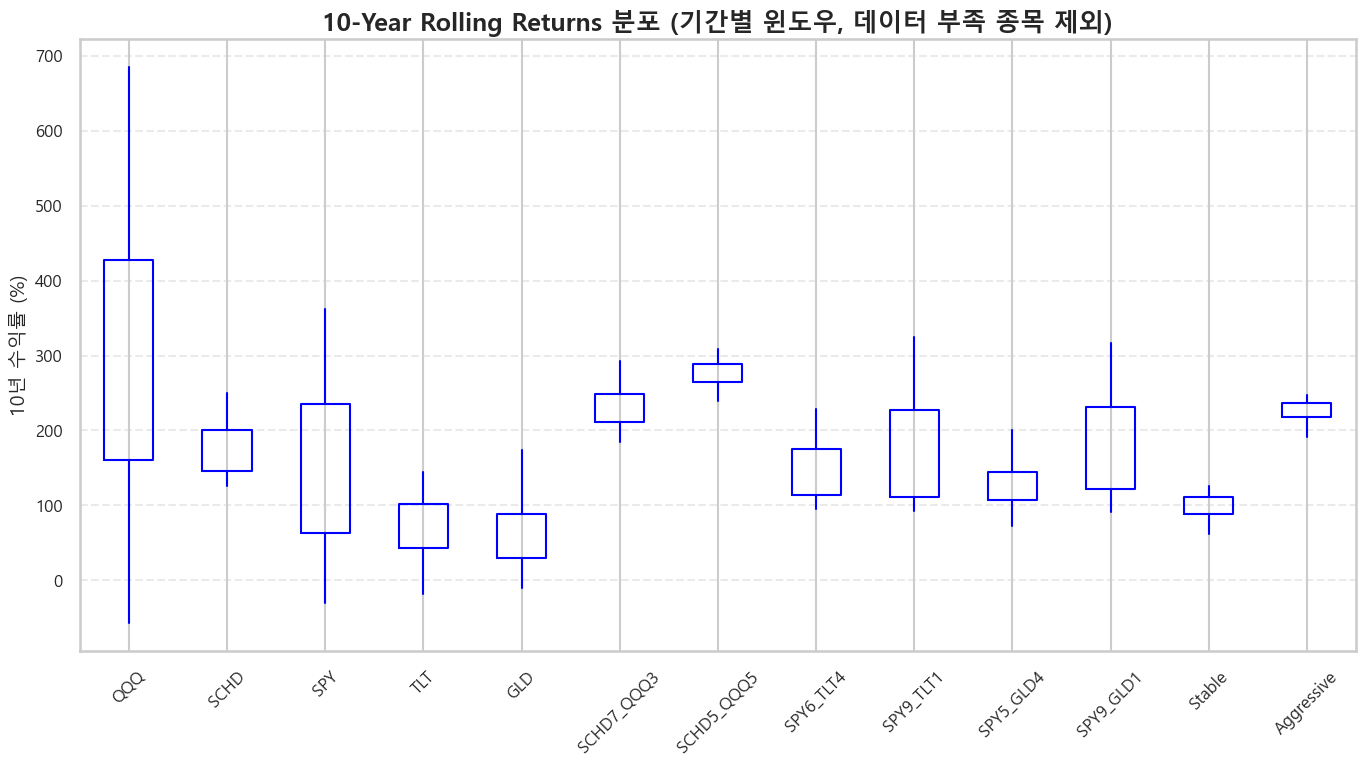

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Stable, Aggressive 포트폴리오 월별 수익률 계산 ---
# portfolios 변수는 이미 정의되어 있다고 가정
portfolio_returns_df = calc_mixed_monthly_return(portfolios, monthly_return_dfs)

# all_returns_df 에 포트폴리오도 추가
all_returns_extended_df = pd.concat([all_returns_df, portfolio_returns_df], axis=1)

# --- 2. rolling window 기간 조절하여 누적 10년 수익률 계산 함수 ---
def calc_rolling_returns_with_variable_window(df_returns, default_window=120, min_window=12, min_counts=30):
    """
    df_returns: 종목별 월별 수익률 데이터프레임
    default_window: 기본 10년 (120개월)
    min_window: 최소 window 크기 (1년=12개월)
    min_counts: rolling 결과 최소 개수 (없으면 제외)
    """
    rolling_returns = {}
    for col in df_returns.columns:
        series = df_returns[col].dropna()
        length = len(series)
        window = min(default_window, max(min_window, length))

        rolling_prod = (1 + series).rolling(window=window, min_periods=window).apply(np.prod, raw=True)
        valid_vals = rolling_prod.dropna()
        if len(valid_vals) >= min_counts:
            rolling_returns[col] = (valid_vals - 1) * 100
        else:
            rolling_returns[col] = pd.Series([np.nan])
    return rolling_returns

# --- 3. rolling 10년 수익률 계산 ---
rolling_10yr_returns = calc_rolling_returns_with_variable_window(all_returns_extended_df)

# --- 4. 충분한 데이터가 있는 종목만 추려서 시각화 데이터 준비 ---
labels = []
data = []
for t, vals in rolling_10yr_returns.items():
    if vals.isna().all():
        print(f"{t} - 데이터 부족으로 시각화 제외")
        continue
    labels.append(t)
    data.append(vals.values)

# --- 5. 박스플롯 그리기 ---
plt.figure(figsize=(14, 8))

box = plt.boxplot(data, tick_labels=labels, vert=True, patch_artist=False, showfliers=False)

for b in box['boxes']:
    b.set_color('blue')
    b.set_linewidth(1.5)

for whisker in box['whiskers']:
    whisker.set_color('blue')
    whisker.set_linewidth(1.5)

for cap in box['caps']:
    cap.set_visible(False)

for median in box['medians']:
    median.set_color('white')
    median.set_linewidth(0)

plt.title('10-Year Rolling Returns 분포 (기간별 윈도우, 데이터 부족 종목 제외)', fontsize=18, weight='bold')
plt.ylabel('10년 수익률 (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

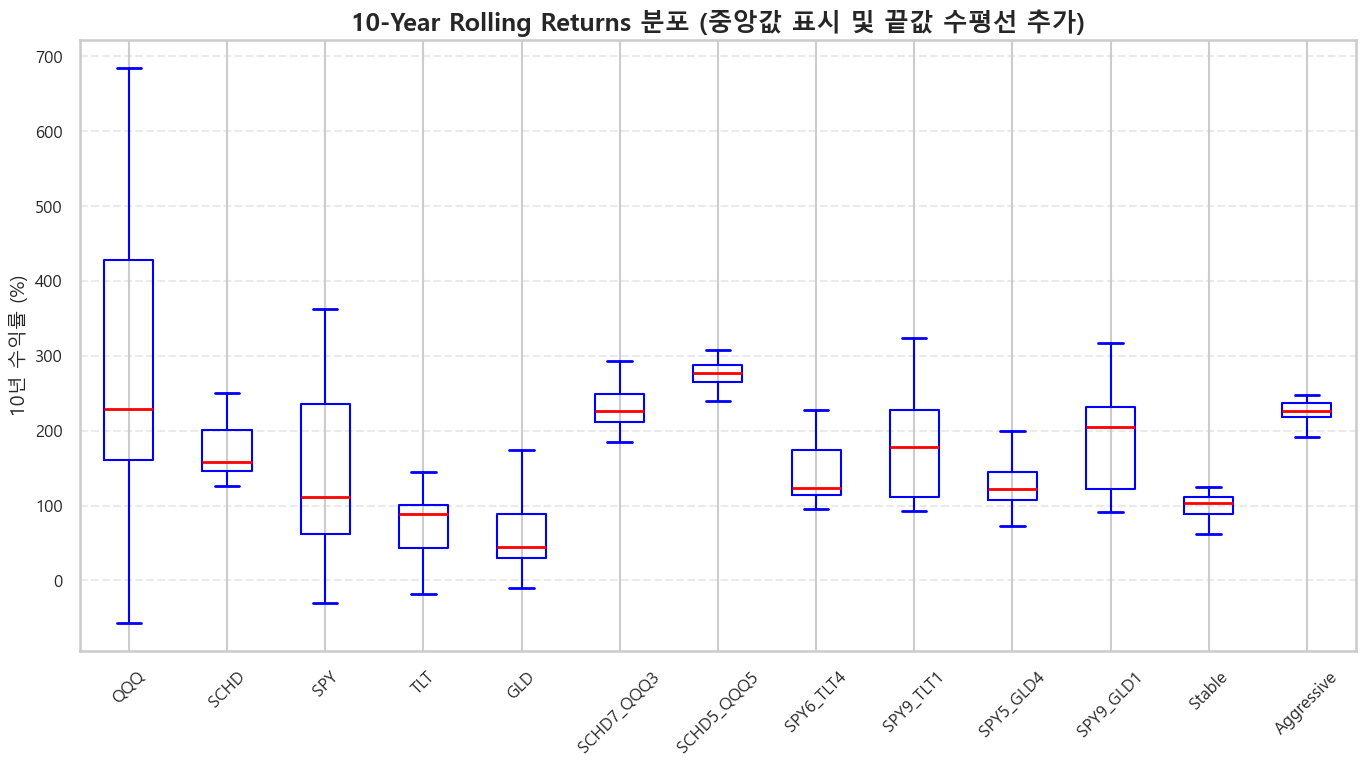

In [29]:
plt.figure(figsize=(14, 8))

box = plt.boxplot(
    data,
    tick_labels=labels,  # labels -> tick_labels 로 변경
    vert=True,
    patch_artist=False,
    showfliers=False
)

# 박스, 수염 스타일 지정 (파란색)
for b in box['boxes']:
    b.set_color('blue')
    b.set_linewidth(1.5)

for whisker in box['whiskers']:
    whisker.set_color('blue')
    whisker.set_linewidth(1.5)

for cap in box['caps']:
    # 끝단 가로선(캡)을 파란색으로 표시하고 두께 키움 (수평선 역할)
    cap.set_color('blue')
    cap.set_linewidth(2)
    cap.set_visible(True)

# 중앙값 선 스타일: 빨간색, 굵게
for median in box['medians']:
    median.set_color('red')
    median.set_linewidth(2)

plt.title('10-Year Rolling Returns 분포 (중앙값 표시 및 끝값 수평선 추가)', fontsize=18, weight='bold')
plt.ylabel('10년 수익률 (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()